# Linear regression approach to ocean bottom. An area.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [2]:
raw_data = pd.read_csv('pratice_values.csv')

In [3]:
raw_data.head()

,Unnamed: 0,channel_number,geophoneDepth,sourceDepth,geophoneDatum,sourceDatum,WBdepth_sourceLocation,WBdepth_geophoneLocation,sourceX,sourceY,geophoneX,geophoneY,shipSpeed,day,hour,minute,sec,shot_number,sequence_number,time
0,78,1,11.1,6.1,0.0,0.0,63.13,64.66,527000.4,6597192.3,527163.4,6597134.0,248,264,3,26,19,1157,1600,22821979
1,79,1,11.0,6.1,0.0,0.0,63.13,64.66,527001.7,6597217.6,527164.9,6597159.7,238,264,3,26,29,1159,1600,22821989
2,80,1,10.9,6.1,0.0,0.0,63.58,64.66,527002.8,6597242.7,527166.3,6597185.3,239,264,3,26,40,1161,1600,22822000
3,81,1,10.7,6.1,0.0,0.0,63.58,62.89,527003.7,6597267.9,527167.4,6597211.1,250,264,3,26,50,1163,1600,22822010
4,82,1,10.6,6.0,0.0,0.0,63.58,62.89,527004.5,6597292.9,527168.5,6597236.7,251,264,3,27,0,1165,1600,22822020


We plot the trajectory of the vessel, with a color scheme representing the speed of ship.

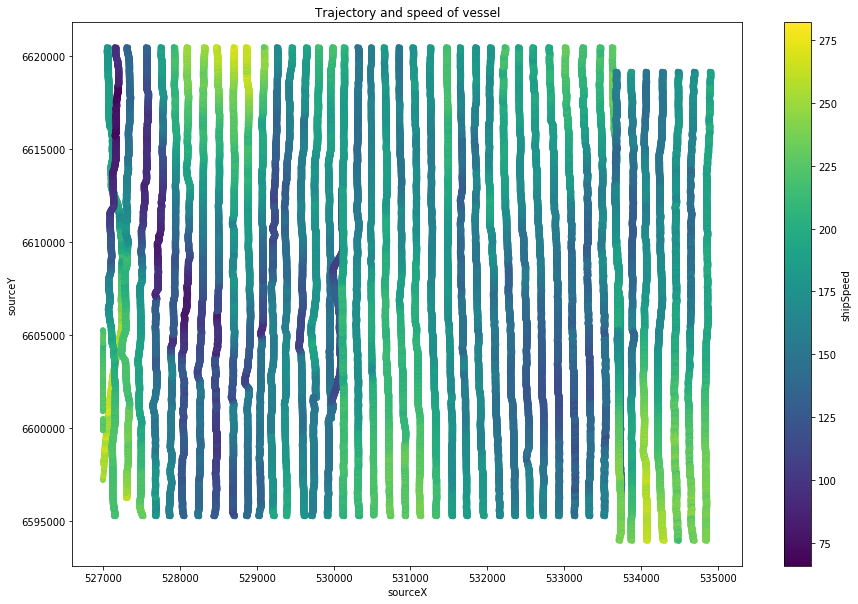

In [9]:
ax= plt.gca()
raw_data.plot(x='sourceX',y='sourceY',kind='scatter',c='shipSpeed',colormap='viridis',ax=ax,figsize=(15,10),title='Trajectory and speed of vessel')

Now we plot the measured ocean bottom depth along the vessel's route. This quantity is hte one we will focus on and model below.

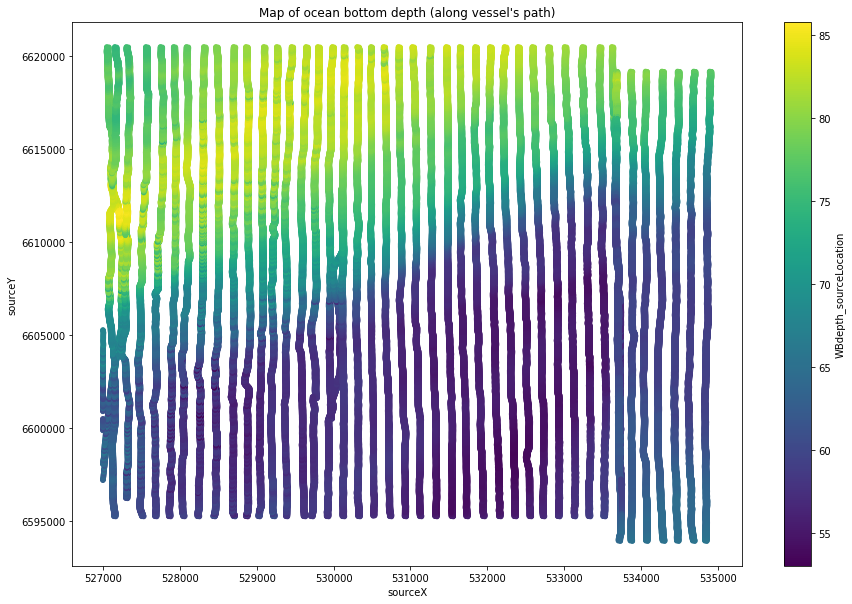

In [7]:
ax= plt.gca()
raw_data.plot(x='sourceX',y='sourceY',kind='scatter',c='WBdepth_sourceLocation',colormap='viridis',ax=ax,figsize=(15,10),title='Map of ocean bottom depth (along vessel\'s path)')

Let's create only one attribute of time by combining: day, hour, minute, second.

In [10]:
raw_data['time'] = raw_data['day']*24*60*60 + raw_data['hour']*60*60 + raw_data['minute']*60 + raw_data['sec']

In [15]:
raw_data.head(3)

,Unnamed: 0,channel_number,geophoneDepth,sourceDepth,geophoneDatum,sourceDatum,WBdepth_sourceLocation,WBdepth_geophoneLocation,sourceX,sourceY,geophoneX,geophoneY,shipSpeed,day,hour,minute,sec,shot_number,sequence_number,time
0,78,1,11.1,6.1,0.0,0.0,63.13,64.66,527000.4,6597192.3,527163.4,6597134.0,248,264,3,26,19,1157,1600,22821979
1,79,1,11.0,6.1,0.0,0.0,63.13,64.66,527001.7,6597217.6,527164.9,6597159.7,238,264,3,26,29,1159,1600,22821989
2,80,1,10.9,6.1,0.0,0.0,63.58,64.66,527002.8,6597242.7,527166.3,6597185.3,239,264,3,26,40,1161,1600,22822000


Note that the sourceDatum, geophoneDatum, and channel number are constant valued, so we will drop them.

In [16]:
raw_data.sourceDatum.min() == raw_data.sourceDatum.max()

True

In [17]:
raw_data.geophoneDatum.min() == raw_data.geophoneDatum.max()

True

In [18]:
raw_data.channel_number.min() == raw_data.channel_number.max()

True

In [19]:
#dropping irrelevant columns. We have the new time attribute so we drop the rest as well.
relevant_data = raw_data.drop(['day','geophoneDatum','sourceDatum','hour','minute','sec','channel_number'],axis=1)

In [26]:
relevant_data['shotSequence'] = relevant_data['shot_number'] + relevant_data['sequence_number']* 10000

In [27]:
relevant_data.head(3)

,Unnamed: 0,geophoneDepth,sourceDepth,WBdepth_sourceLocation,WBdepth_geophoneLocation,sourceX,sourceY,geophoneX,geophoneY,shipSpeed,shot_number,sequence_number,time,shotSequence
0,78,11.1,6.1,63.13,64.66,527000.4,6597192.3,527163.4,6597134.0,248,1157,1600,22821979,16001157
1,79,11.0,6.1,63.13,64.66,527001.7,6597217.6,527164.9,6597159.7,238,1159,1600,22821989,16001159
2,80,10.9,6.1,63.58,64.66,527002.8,6597242.7,527166.3,6597185.3,239,1161,1600,22822000,16001161


# Modeling WBdepth_sourceLocation (water bottom depth at source)

#### We will create an instance of KFold to create different training/validation sets

In [28]:
kfolds = KFold(n_splits=10,shuffle=True,random_state=0)

#### We use LASSO to do feature selection

In [29]:
relevant_data.columns

Index(['Unnamed: 0', 'geophoneDepth', 'sourceDepth', 'WBdepth_sourceLocation',
       'WBdepth_geophoneLocation', 'sourceX', 'sourceY', 'geophoneX',
       'geophoneY', 'shipSpeed', 'shot_number', 'sequence_number', 'time',
       'shotSequence'],
      dtype='object')

In [30]:
waterDepthAttributes = ['geophoneDepth', 'sourceDepth',
       'WBdepth_geophoneLocation', 'sourceX', 'sourceY', 'geophoneX',
       'geophoneY', 'shipSpeed', 'shot_number', 'sequence_number', 'time','shotSequence']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(relevant_data[waterDepthAttributes],relevant_data['WBdepth_sourceLocation'],random_state=0)

In [37]:
alpha_rss_lasso = []

for Alpha in np.logspace(-3,2,10):
    
    temp_rss = []
    for trainIndex, valIndex in kfolds.split(X_train):
        
        model_temp = Lasso(alpha=Alpha, fit_intercept=True, normalize=True, random_state=0).fit(X_train.iloc[trainIndex],y_train.iloc[trainIndex])
        y_pred_temp = model_temp.predict(X_train.iloc[valIndex])
        temp_rss.append( ((y_pred_temp - y_train.iloc[valIndex])**2).sum() )
    
        if list(np.nonzero(model_temp.coef_)[0]) and Alpha > 0.001:
            print('At alpha =', Alpha, 'nonzero coefficients are:')
            print(list(np.nonzero(model_temp.coef_)[0]))
        
    alpha_rss_lasso.append(np.mean(temp_rss))

/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/cabrera/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective di

At alpha = 0.003593813663804626 nonzero coefficients are:
[2, 4, 5, 6, 7, 10]
At alpha = 0.003593813663804626 nonzero coefficients are:
[2, 4, 5, 6, 7, 10]
At alpha = 0.003593813663804626 nonzero coefficients are:
[2, 4, 5, 6, 7, 10]
At alpha = 0.003593813663804626 nonzero coefficients are:
[2, 4, 5, 6, 7, 10]
At alpha = 0.003593813663804626 nonzero coefficients are:
[2, 4, 5, 6, 7, 10]
At alpha = 0.003593813663804626 nonzero coefficients are:
[2, 4, 5, 6, 7, 10]
At alpha = 0.003593813663804626 nonzero coefficients are:
[2, 4, 5, 6, 7, 10]
At alpha = 0.003593813663804626 nonzero coefficients are:
[2, 4, 5, 6, 7, 10]
At alpha = 0.003593813663804626 nonzero coefficients are:
[2, 4, 5, 6, 7, 10]
At alpha = 0.003593813663804626 nonzero coefficients are:
[2, 4, 5, 6, 7, 10]
At alpha = 0.01291549665014884 nonzero coefficients are:
[4]
At alpha = 0.01291549665014884 nonzero coefficients are:
[4]
At alpha = 0.01291549665014884 nonzero coefficients are:
[4]
At alpha = 0.01291549665014884 nonzer

(-0.1, 1)

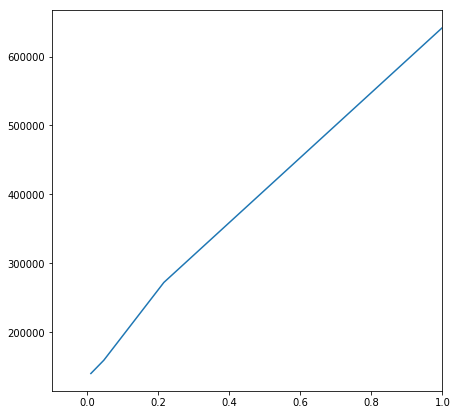

In [29]:
plt.figure(figsize=(7,7))
plt.plot(np.logspace(-2,4,10), alpha_rss_lasso)
plt.xlim(-.1,1)

In [39]:
selectedAttributes = ['WBdepth_geophoneLocation', 'sourceX', 'sourceY', 'geophoneX',
       'geophoneY', 'shipSpeed', 'time','shotSequence']

## Ridge regression with selected attributes

In [40]:
X_train_selected = X_train[selectedAttributes].copy()
X_test_selected = X_test[selectedAttributes].copy()

In [41]:
X_train_selected.head(4)

,WBdepth_geophoneLocation,sourceX,sourceY,geophoneX,geophoneY,shipSpeed,time,shotSequence
2207,64.79,527149.1,6599615.1,527313.9,6599534.5,226,22738784,16321351
19630,70.55,528691.1,6607904.6,528863.2,6607785.0,178,22273735,17602014
33581,77.73,529927.0,6613405.2,530079.3,6613268.7,172,24060959,18722454
8385,62.49,527699.9,6604513.4,527860.2,6604417.2,139,22571728,16801743


In [42]:
ridge_w_RSS = []
for Lambda in np.logspace(-4,2):
    
    temp_rss = []
    
    for trainIndex, testIndex in kfolds.split(X_train_selected):
    
        ridge = Ridge(alpha=Lambda, fit_intercept=True, normalize=True,random_state=0).fit(X_train_selected.iloc[trainIndex],y_train.iloc[trainIndex])
        temp_rss.append(((y_train.iloc[testIndex] - ridge.predict(X_train_selected.iloc[testIndex]))**2 ).sum())
    
    ridge_w_RSS.append(np.mean(temp_rss))

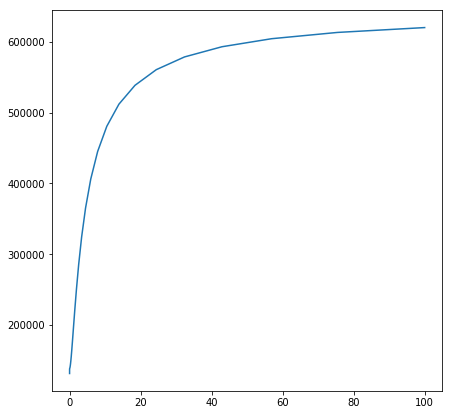

In [43]:
plt.figure(figsize=(7,7))
plt.plot(np.logspace(-4,2), ridge_w_RSS)

Let's look at the path of coefficients

In [35]:
ridge_coeff = []
for Lambda in np.logspace(-4,2):
    ridge =  Ridge(alpha=Lambda, fit_intercept=True, normalize=True,random_state=0).fit(X_train_selected.iloc[trainIndex],y_train.iloc[trainIndex])
    ridge_coeff.append(ridge.coef_)
    
ridge_coeff_path = np.array(ridge_coeff).transpose()

Text(0,0.5,'coefficient value')

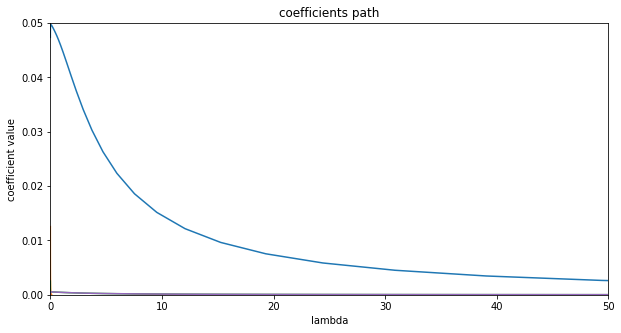

In [38]:
plt.figure(figsize=(10,5))
for x in range(5):
    plt.plot(np.logspace(-3,2),ridge_coeff_path[x])
plt.ylim(0,0.05)
plt.xlim(0,50)
plt.title('coefficients path')
plt.xlabel('lambda')
plt.ylabel('coefficient value')

We can see from the above plots that the values of the linear regression coefficients are never too big, even at the lowest values of Lambda. Therefore there is not a lot of overfitting. Therefore we can move forward to model using Ridge regression using the smallest Lambda:

In [45]:
ridge_1 = Ridge(alpha=.0001, fit_intercept=True, normalize=True,random_state=0).fit(X_train_selected,y_train)
y_pred_ridge = ridge_1.predict(X_test_selected)

## Let's plot the result

In [46]:
regression_results = X_test_selected.copy()
regression_results['WBdepth_sourceLocation'] = y_test
regression_results['y_pred_ridge'] = y_pred_ridge

In [41]:
regression_results.head(3)

,WBdepth_geophoneLocation,sourceX,sourceY,geophoneX,geophoneY,shipSpeed,time,shotSequence,WBdepth_sourceLocation,y_pred_ridge
369,60.14,534463.7,6609919.6,534303.1,6610046.5,174,24031012,22242182,60.07,67.003572
197,57.77,530335.5,6600165.3,530493.7,6600078.8,184,24136384,19041395,57.65,58.974179
717,74.44,531478.1,6613178.8,531640.0,6613052.4,192,24468664,20002436,74.71,71.909447


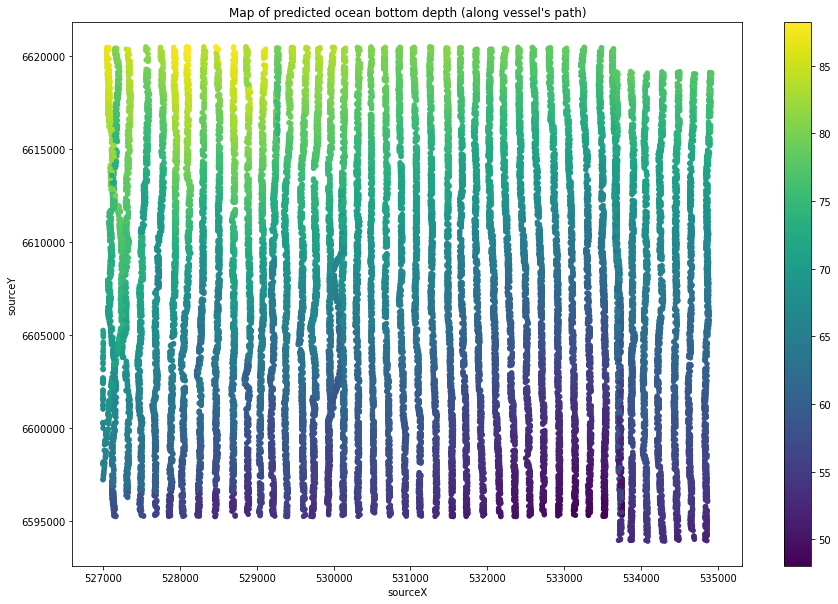

In [48]:
ax = plt.gca()
regression_results.plot(x='sourceX',y='sourceY',kind='scatter',c=y_pred_ridge,colormap='viridis',ax=ax,figsize=(15,10),title='Map of predicted ocean bottom depth (along vessel\'s path)')

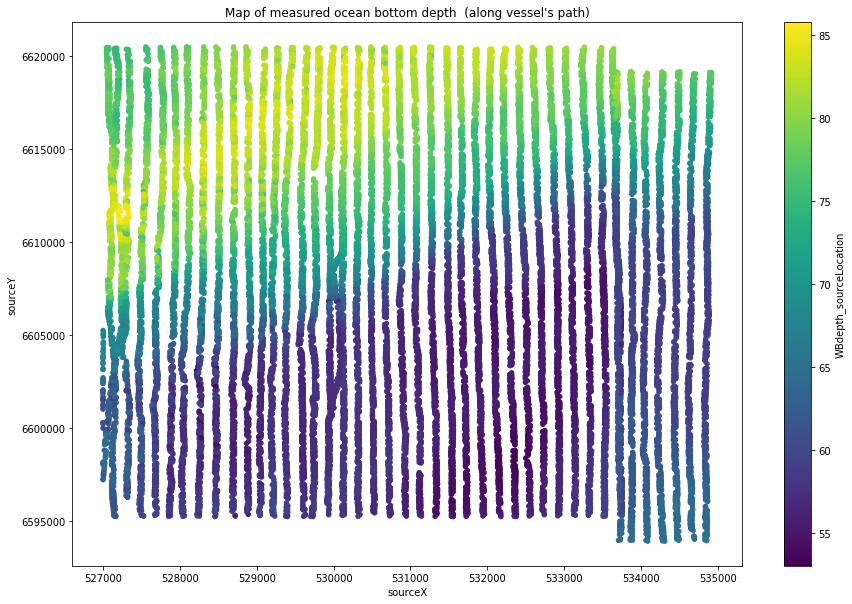

In [50]:
ax=plt.gca()
regression_results.plot(x='sourceX',y='sourceY',kind='scatter',c='WBdepth_sourceLocation',colormap='viridis',ax=ax,figsize=(15,10),title='Map of measured ocean bottom depth  (along vessel\'s path)')

We see that even though not as granular as the actually measured values, the linear regression model does have the over all picture well captured.

Let's plot the difference between the measured values and the respective regression predictions.

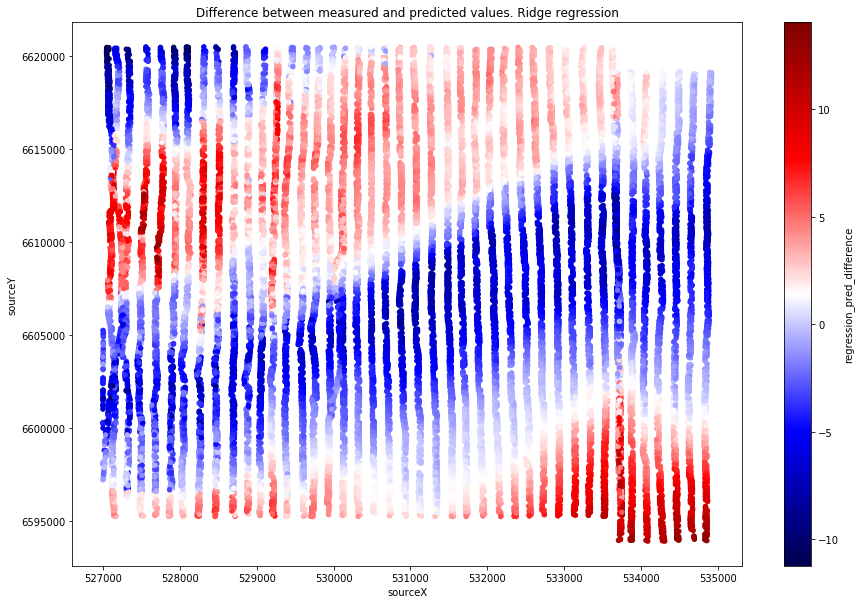

In [51]:
regression_results['regression_pred_difference'] = regression_results['WBdepth_sourceLocation'] - regression_results['y_pred_ridge']
ax= plt.gca()
regression_results.plot(x='sourceX',y='sourceY',c='regression_pred_difference',kind='scatter',colormap='seismic',figsize=(15,10),ax=ax,title='Difference between measured and predicted values. Ridge regression')

# Modeling via kNN linear regression

We first scan for the appropriate k value.

In [53]:
knn_rss = []
for k in range(1,100,4):
    
    temp_rss = []
    
    for trainIndex, testIndex in kfolds.split(X_train_selected):
    
        knn_model_temp = KNeighborsRegressor(n_neighbors=k,weights='distance').fit(X_train_selected.iloc[trainIndex],y_train.iloc[trainIndex])
        temp_rss.append(((y_train.iloc[testIndex] - knn_model_temp.predict(X_train_selected.iloc[testIndex]))**2 ).sum())
    
    knn_rss.append(np.mean(temp_rss))

(-1, 50)

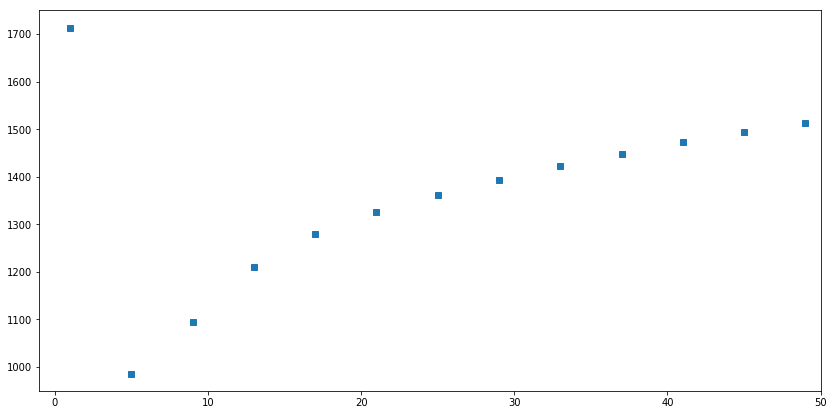

In [79]:
plt.figure(figsize=(14,7))
plt.plot(list(range(1,100,4)),knn_rss,'s')
plt.xlim(-1,50)

In [57]:
knn_rss_small = []
for k in range(1,20,1):
    
    temp_rss = []
    
    for trainIndex, testIndex in kfolds.split(X_train_selected):
    
        knn_model_temp = KNeighborsRegressor(n_neighbors=k,weights='distance').fit(X_train_selected.iloc[trainIndex],y_train.iloc[trainIndex])
        temp_rss.append(((y_train.iloc[testIndex] - knn_model_temp.predict(X_train_selected.iloc[testIndex]))**2 ).sum())
    
    knn_rss_small.append(np.mean(temp_rss))

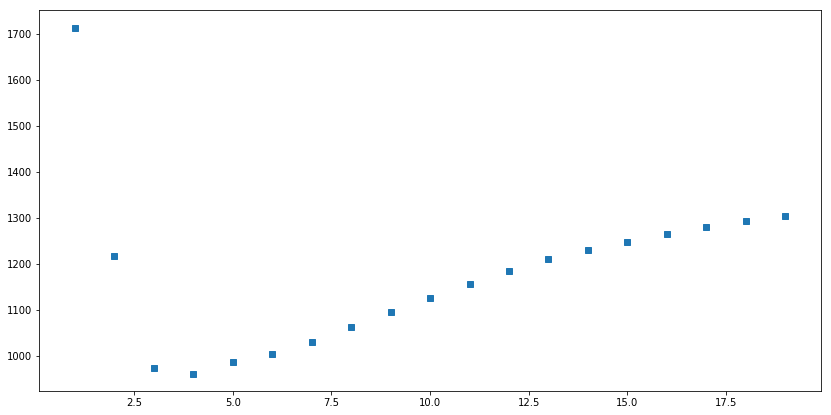

In [60]:
plt.figure(figsize=(14,7))
plt.plot(list(range(1,20,1)),knn_rss_small,'s')

__We will use k = 4.__

In [61]:
knn_model_4 = KNeighborsRegressor(n_neighbors=4,weights='distance').fit(X_train_selected,y_train)
y_pred_knn4 = knn_model_4.predict(X_test_selected)

Let's create a plot with the knn predictions:

In [62]:
regression_results['y_pred_knn4'] = y_pred_knn4

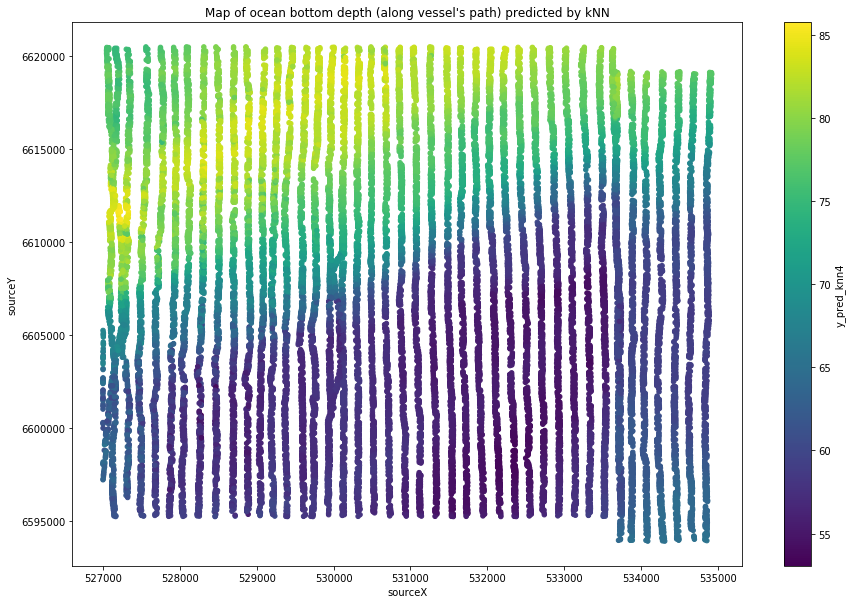

In [66]:
ax= plt.gca()
regression_results.plot(x='sourceX',y='sourceY',c='y_pred_knn4',kind='scatter',colormap='viridis',figsize=(15,10),ax=ax,title='Map of ocean bottom depth (along vessel\'s path) predicted by kNN')

Let's plot the difference:

In [68]:
regression_results['kNN_pred_difference'] = regression_results['WBdepth_sourceLocation'] - regression_results['y_pred_knn4']

In [73]:
regression_results['kNN_pred_difference'].min()

-6.9911573972571404

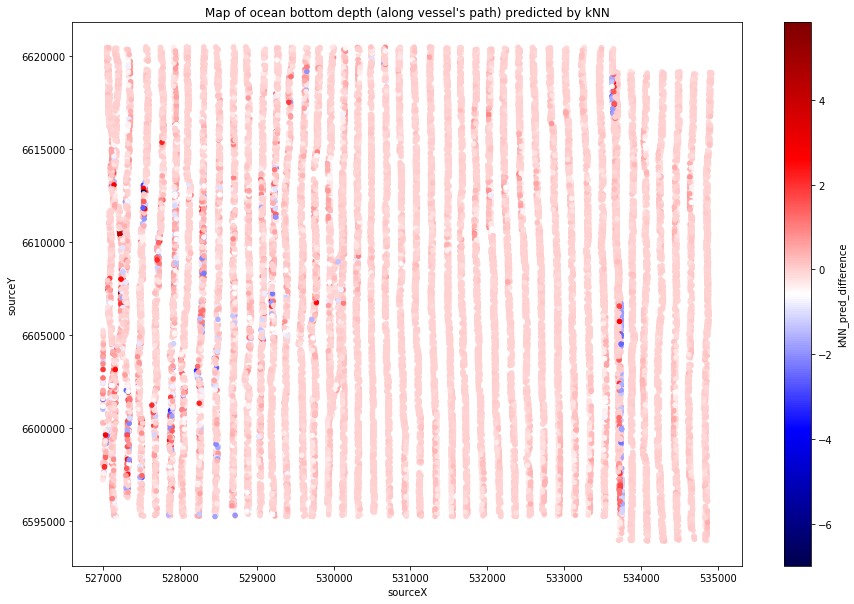

In [80]:
ax= plt.gca()
regression_results.plot(x='sourceX',y='sourceY',c='kNN_pred_difference',kind='scatter',colormap='seismic',figsize=(15,10),ax=ax,title='Map of ocean bottom depth (along vessel\'s path) predicted by kNN')

# Interpretation

Whether to use kNN regression or Ridge linear regression depends on the density in the xy-plane of the values we are trying the predict. 

If the missing values are sparse, we should use the kNN approach since it can capture the finer details of the ocean bottom better provided we have enough data to model. 

On the other hand, if the missing values of the ocean depth a more densely located, for example, trying to predict a long portion of a group of sail lines (segments of the ship path), then the kNN would not give better results. The lack of neighbors in the region would make predictions based on constant values coming from polling the points far away. Then we should rely on the linear regression model because it has a longer wavelength.